In [27]:
#!pip install tensorflow keras split-folders opencv-python
#!pip install split-folders

## Bibliotecas

In [1]:
import random
import cv2
import os
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

2025-06-04 22:28:41.283459: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 22:28:41.411434: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-04 22:28:41.522983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749086921.614262   29640 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749086921.639760   29640 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749086921.841921   29640 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Preparando as Imagens

In [29]:
# Executar essa cédula pra conectar o Colab ao Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
input_folder = "bloodcells_dataset_reduced"
output_folder = "image_recognition"

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


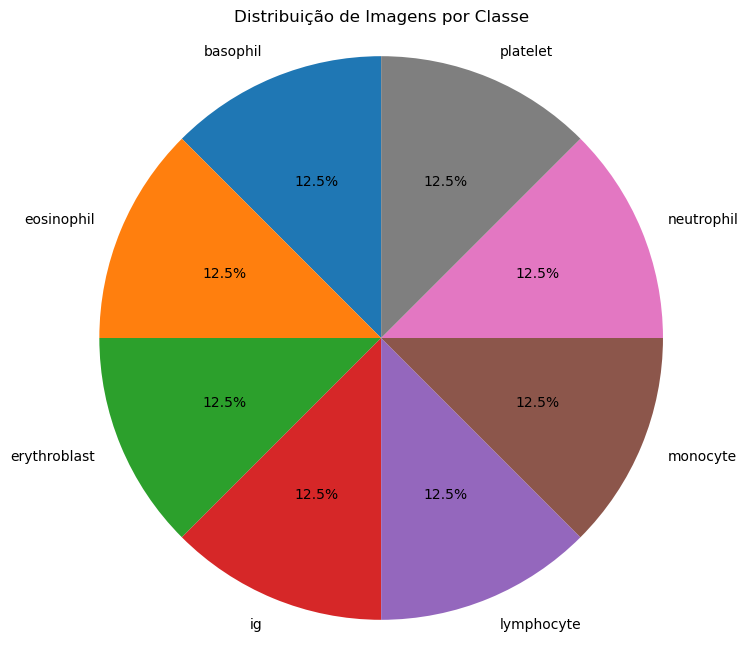


Contagem de imagens por classe:
- basophil: 500
- eosinophil: 500
- erythroblast: 500
- ig: 500
- lymphocyte: 500
- monocyte: 500
- neutrophil: 500
- platelet: 500


In [ ]:
# Obtém os nomes das classes (subdiretórios) e ordena
class_names = sorted([d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))])

if not class_names:
    print(f"Nenhuma subpasta (classe) encontrada em '{input_folder}'.")
else:
    # Conta o número de arquivos em cada classe
    image_counts = [len(os.listdir(os.path.join(input_folder, class_name))) for class_name in class_names]
    if sum(image_counts) == 0:
        print("Nenhuma imagem encontrada nas classes.")
    else:
        # Cria o gráfico de pizza
        plt.figure(figsize=(8, 8))
        plt.pie(image_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
        plt.title('Distribuição de Imagens por Classe')
        plt.axis('equal') # Garante que o gráfico seja um círculo
        plt.show()
        
        print("\nContagem de imagens por classe:")
        for name, count in zip(class_names, image_counts):
            print(f"- {name}: {count}")

In [ ]:
# Cria as pastas test, train e val no image_recognition
# split_ratio = (0.8, 0.1, 0.1)
# splitfolders.ratio(
#     input_folder,
#     output=output_folder,
#     seed=42,
#     ratio=split_ratio,
#     group_prefix=None
# )


Copying files: 4000 files [00:00, 10595.28 files/s]


In [6]:
# Define the parameters
img_size = (360, 360)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,    # resnet50
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
train_dir = os.path.join(output_folder, 'train')
test_dir = os.path.join(output_folder, 'test')
valid_dir = os.path.join(output_folder, 'val')

In [9]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Evita inconsistência na predição
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [36]:
# Get a batch of images and labels
images, labels = next(valid_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..131.32].


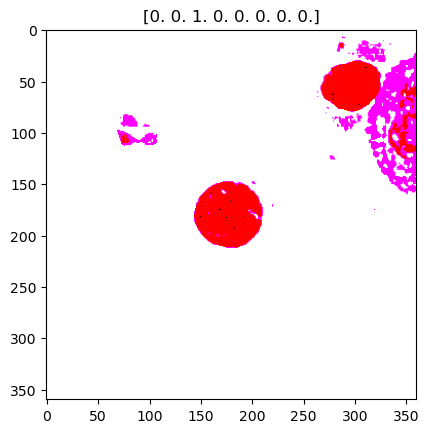

In [37]:
# Select a random image from the batch
idx =  random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.title(labels[idx])
plt.show()

## Configurando o Modelo

In [10]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

2025-06-04 22:31:30.557482: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

In [62]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 12, 12, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,377,626 (92.99 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 526,610 (2.01 MB)

In [13]:
# Rodar apenas se tiver o treinamento já carregado
# model.load_weights('/content/drive/MyDrive/IA/bloodcells_image_recognition/CropModel.keras')
model.load_weights('CropModel.keras')

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Treinamento e Validação

In [ ]:
# Rodar apenas ao treinar o algoritmo
# history = model.fit(train_data, epochs=10, validation_data=valid_data)

/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.2460 - loss: 1.9970 - val_accuracy: 0.5750 - val_loss: 1.2608
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.5229 - loss: 1.3202 - val_accuracy: 0.7300 - val_loss: 0.8455
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.6416 - loss: 1.0265 - val_accuracy: 0.7650 - val_loss: 0.7552
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.6775 - loss: 0.9306 - val_accuracy: 0.7850 - val_loss: 0.6276
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.7095 - loss: 0.8458 - val_accuracy: 0.8050 - val_loss: 0.5761
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.7332 - loss: 0.7710 - val_accuracy: 0.8150 - val_loss: 0.5669
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.7407 - loss: 0.7386 - val_accuracy: 0.8100 - val_loss: 0.5788
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.7394 - loss: 0.7068 - val_accu

In [ ]:
# Salva o histórico do treinamento
# df_history = pd.DataFrame(history.history)
# df_history.to_csv('training_history_sequential.csv', index_label='epoch') # index_label para nomear a coluna do índice (épocas)

# Carrega o histórico da rede neural previamente treinada
df_loaded_history = pd.read_csv('training_history_sequential.csv', index_col='epoch')
# Para converter de volta para um dicionário similar ao original (se necessário):
history = df_loaded_history.to_dict(orient='list')

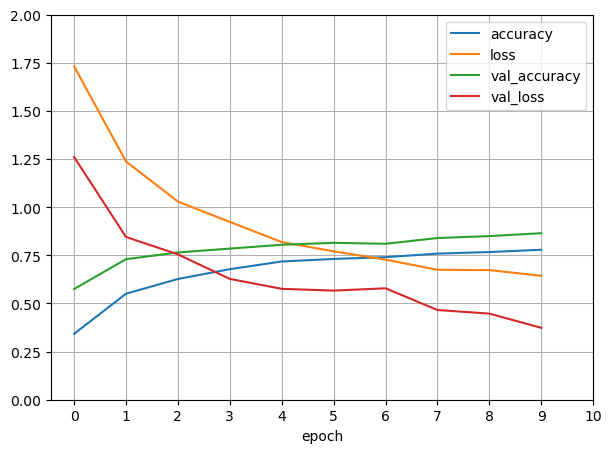

In [94]:
pd.DataFrame(history).plot(figsize=(7, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.xticks([x for x in range(0, 11)])
plt.xlabel('epoch')
plt.show()

In [55]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8804 - loss: 0.3911
Test accuracy: 89.00%
Test loss: 35.85%


In [15]:
class_names = {0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3:'ig', 4:'lymphocyte',
               5:'monocyte', 6:'neutrophil', 7:'platelet'}

In [16]:
def predict_img(image,model):
    test_img=cv2.imread(image)
    test_img=cv2.resize(test_img, img_size)
    test_img=np.expand_dims(test_img, axis=0)
    result=model.predict(test_img)
    r=np.argmax(result)
    print(class_names[r])

In [58]:
predict_img('image_recognition/train/ig/MMY_21284.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
ig


In [17]:
# Certifique-se de que o modelo está carregado ou treinado antes de executar esta célula.
# Se você não treinou o modelo na sessão atual e está apenas carregando os pesos,
# verifique se a célula model.load_weights() foi executada sem erros.

# 1. Fazer previsões no conjunto de teste
# O número de passos deve cobrir todo o conjunto de teste
num_test_samples = test_data.samples
# Se test_data.batch_size foi alterado para predição, use esse valor, senão use o batch_size original
# Para garantir, podemos recalcular batch_size aqui se necessário ou usar o global

# Y_pred_probs conterá as probabilidades para cada classe
Y_pred_probs = model.predict(test_data, steps=int(np.ceil(num_test_samples / test_data.batch_size)))

# Y_pred conterá a classe predita (o índice da classe com maior probabilidade)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# 2. Obter os rótulos verdadeiros
# Como definimos shuffle=False para test_data, test_data.classes nos dará os rótulos na ordem correta
Y_true = test_data.classes

# 3. Obter os nomes das classes para o plot
# Precisamos deles como uma lista na ordem dos índices para o heatmap
target_names = [class_names[i] for i in range(len(class_names))]

/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-06-04 22:33:49.197182: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 49766400 exceeds 10% of free system memory.
2025-06-04 22:33:49.417330: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 49766400 exceeds 10% of free system memory.
2025-06-04 22:33:50.160497: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51439104 exceeds 10% of free system memory.
2025-06-04 22:33:50.168817: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 265420800 exceeds 10% of free system memory.
20

13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step


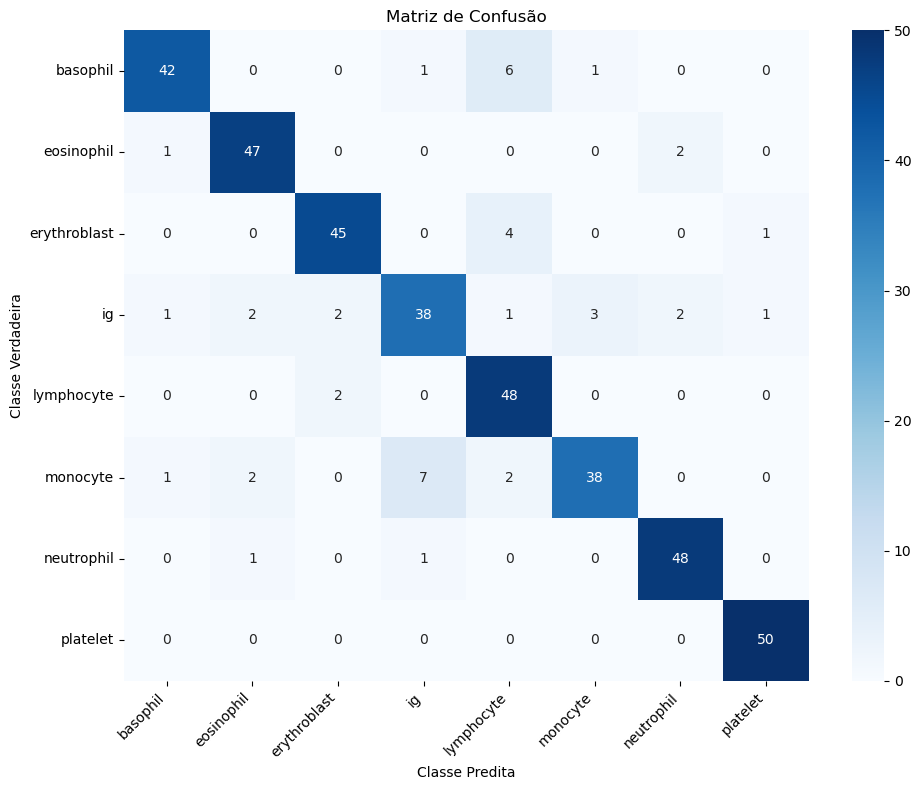


Relatório de Classificação:
              precision    recall  f1-score   support

    basophil       0.93      0.84      0.88        50
  eosinophil       0.90      0.94      0.92        50
erythroblast       0.92      0.90      0.91        50
          ig       0.81      0.76      0.78        50
  lymphocyte       0.79      0.96      0.86        50
    monocyte       0.90      0.76      0.83        50
  neutrophil       0.92      0.96      0.94        50
    platelet       0.96      1.00      0.98        50

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [ ]:
# 4. Calcular a matriz de confusão
cm = confusion_matrix(Y_true, Y_pred)

# 5. Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham
plt.show()

# 6. (Opcional) Exibir o relatório de classificação para mais métricas (precisão, recall, f1-score)
print("\nRelatório de Classificação:")
print(classification_report(Y_true, Y_pred, target_names=target_names))


Iniciando análise t-SNE...
Criando extrator de features com a API Funcional...
Extraindo features para o t-SNE do conjunto de teste...
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step
Shape das features extraídas: (400, 128)
Shape dos rótulos: (400,)
Aplicando t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.732381


/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.260735
[t-SNE] KL divergence after 1000 iterations: 0.454041
Shape dos resultados do t-SNE: (400, 2)


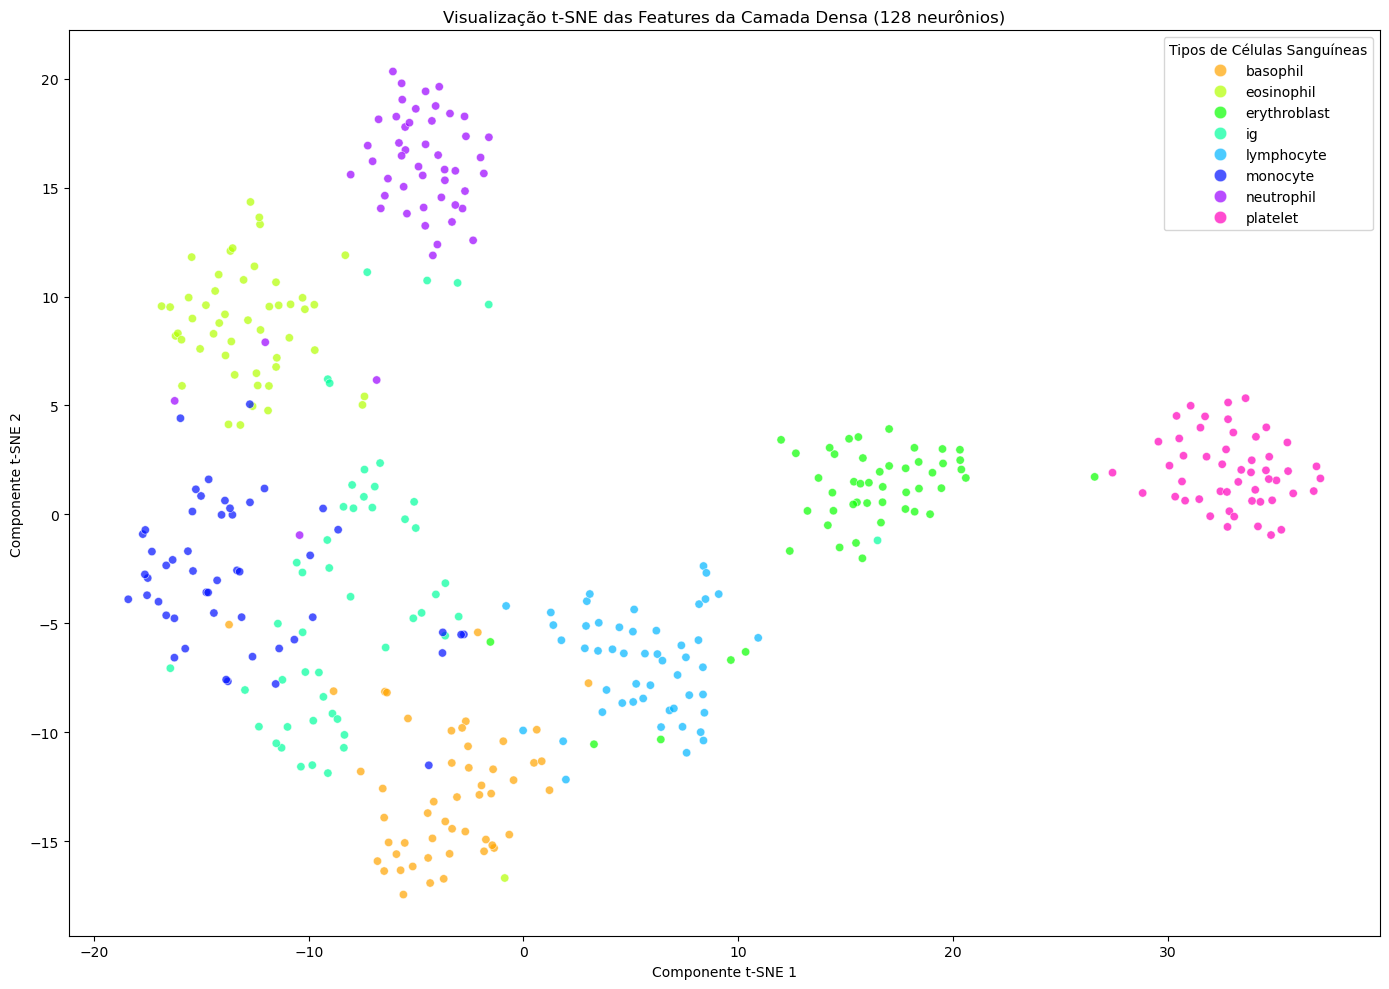

Análise t-SNE concluída.


In [21]:
# Adicione esta importação no início do seu notebook, junto com as outras,
# ou apenas nesta célula se preferir.
from sklearn.manifold import TSNE

print("\nIniciando análise t-SNE...")

# 1. Criar um modelo para extrair features da camada 'dense' usando a API Funcional
print("Criando extrator de features com a API Funcional...")

# Define um novo tensor de entrada com o shape esperado pelo modelo
# img_size já deve estar definido (ex: (360, 360))
new_input = tf.keras.Input(shape=(img_size[0], img_size[1], 3), name="tsne_input")

# Pega as camadas do modelo original 'model'
# model.layers[0] é o base_model
# model.layers[1] é GlobalAveragePooling2D
# model.layers[2] é a camada Dense(128, activation='relu') que você nomeou como 'dense'

# Passa o novo tensor de entrada pelas camadas relevantes
x = model.layers[0](new_input)  # Passa pela base_model (ResNet50)
x = model.layers[1](x)          # Passa pela GlobalAveragePooling2D
dense_layer_output = model.layers[2](x) # Saída da camada 'dense' (Dense(128))

# Cria o modelo extrator de features
feature_extractor_model = models.Model(inputs=new_input, outputs=dense_layer_output)


# 2. Extrair features do conjunto de teste
# Reutilizamos test_data e Y_true que já foram definidos anteriormente no seu notebook
# num_test_samples já foi definido como test_data.samples
# test_data.batch_size também já está definido
print("Extraindo features para o t-SNE do conjunto de teste...")
features = feature_extractor_model.predict(test_data, 
                                           steps=int(np.ceil(num_test_samples / test_data.batch_size)),
                                           verbose=1)

# Y_true (test_data.classes) já contém os rótulos verdadeiros do conjunto de teste
labels_for_tsne = Y_true 

print(f"Shape das features extraídas: {features.shape}")
print(f"Shape dos rótulos: {labels_for_tsne.shape}")

# 3. Aplicar o t-SNE
# Pode ser demorado para muitos dados. Considere usar um subconjunto se necessário.
# Parâmetros comuns: n_components=2 (para visualização 2D), random_state para reprodutibilidade.
# perplexity é um parâmetro importante; valores entre 5 e 50 são comuns.
# n_iter é o número de iterações.
print("Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(features)

print("Shape dos resultados do t-SNE:", tsne_results.shape)

# 4. Visualizar os resultados do t-SNE
# class_names já está definido no seu notebook
# {0: 'basophil', 1: 'eosinophil', ..., 7:'platelet'}

# Criar um DataFrame para facilitar a plotagem
df_tsne = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
df_tsne['label'] = labels_for_tsne
# Mapear os rótulos numéricos para os nomes das classes
df_tsne['class_name'] = df_tsne['label'].map(class_names)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_name",
    palette=sns.color_palette("hsv", n_colors=len(class_names)), # Você pode escolher outras paletas
    data=df_tsne,
    legend="full",
    alpha=0.7 # Ajuste a transparência se os pontos estiverem muito sobrepostos
)
plt.title('Visualização t-SNE das Features da Camada Densa (128 neurônios)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(title='Tipos de Células Sanguíneas', loc='best', markerscale=1.5)
plt.tight_layout()
plt.show()

print("Análise t-SNE concluída.")

In [24]:
test_data

In [ ]:
# Necessário rodar essa célula para salvar os pesos do treinamento
# model.save('CropModel.keras')